# Proyecto: Descifrando Mensajes Codificados Usando MCMC

Integrantes: Sebastián Flores y Matías Neto

## Procesamiento de la fuente de texto

In [4]:
pip install pycipher

Note: you may need to restart the kernel to use updated packages.


In [5]:
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pycipher import SimpleSubstitution

random.seed(2012)

In [9]:
# Cargar el texto
with open("gloria_benitoperezgaldos.txt", encoding="utf8") as f:
    text = f.readlines()

for i in range(len(text)):
    text[i] = text[i].replace('\n', '')

text = ' '.join(text)

In [10]:
# Sólo minúsculas
clean_text = text.casefold()

# Eliminar tildes
tilde_dict = {'á':'a', 'é': 'e', 'í': 'i', 'ó':'o', 'ú':'u', 'ñ': 'n'}
for key, value in tilde_dict.items():
    clean_text = clean_text.replace(key, value)

# Eliminar caracteres especiales
clean_text = re.sub(r"[^a-zA-Z ]", "", clean_text)
clean_text = clean_text.upper()
alphabet = sorted(''.join(set(clean_text)))

In [11]:
def process(word, matrix):
    '''
    Almacena la frecuencia de transiciones de una palabra en una matriz
    
    Argumentos:
        word (string): Palabra a procesar
        matrix (pd.DataFrame): Matriz de transición
    
    Retorna:
        matrix (pd.DataFrame): Matriz de transición actualizada con
                               la palabra procesada
    '''
    letters = list(word)
    matrix.loc[' ', letters[0]] = matrix.loc[' ', letters[0]] + 1
    for i in range(len(word)-1):
        matrix.loc[letters[i], letters[i+1]] = matrix.loc[letters[i], letters[i+1]] + 1
    matrix.loc[letters[len(word)-1], ' '] = matrix.loc[letters[len(word)-1], ' '] + 1
    return matrix

In [12]:
# Creación de la matriz
matrix = pd.DataFrame(data=np.zeros((len(alphabet), len(alphabet))), index=alphabet, columns=alphabet)
words = clean_text.split()

# Se demora unos minutos
for word in words:
    matrix = process(word, matrix)
transition = matrix.apply(lambda x: x/np.sum(x), axis=1)
transition.to_csv("matrices/bigram.csv")

KeyboardInterrupt: 

In [13]:
# Saltarse la creación de la matriz: Leerla de un archivo
transition = pd.read_csv("matrices/bigram.csv", index_col=0)

## Definición de funciones auxiliares para la minimización

In [15]:
def plausibility(ciphertext, key):
    '''
    Función de plausibilidad que tiene el rol de -U para SA
    
    Argumentos:
        ciphertext (string): Texto codificado
        key (string): Clave del mismo largo que el alfabeto a testear
        matrix (pd.DataFrame): Matriz de transición construida antes
    
    Retorna:
        plausibility (float): valor de la plausibilidad para key
    '''
    cipher = SimpleSubstitution(key)
    plaintext = cipher.decipher(ciphertext, keep_punct = True)
    words = plaintext.split()
    matrix = pd.DataFrame(data=np.zeros((len(alphabet), len(alphabet))), index=alphabet, columns=alphabet)
    for word in words:
        matrix = process(word, matrix)
    plausibility = np.sum((1 + matrix.to_numpy()) * np.log(1 + transition.to_numpy()))
    return plausibility

# Ejemplo
plaintext = "MUCHOS ANOS DESPUES FRENTE AL PELOTON DE FUSILAMIENTO " + \
            "EL CORONEL AURELIANO BUENDIA RECORDO AQUELLA TARDE REMOTA " + \
            "EN QUE SU PADRE LO LLEVO A CONOCER EL HIELO"
real_key = "AJPCZWRLFBDKOTYUQGENHXMIVS"
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(plaintext, keep_punct = True)
print(f"Texto cifrado: {ciphertext}")
print(f"Plausibilidad: {plausibility(ciphertext, real_key)}")

Texto cifrado: OHPLYE ATYE CZEUHZE WGZTNZ AK UZKYNYT CZ WHEFKAOFZTNY ZK PYGYTZK AHGZKFATY JHZTCFA GZPYGCY AQHZKKA NAGCZ GZOYNA ZT QHZ EH UACGZ KY KKZXY A PYTYPZG ZK LFZKY
Plausibilidad: 47.44776747911044


In [16]:
# Ejemplo para ver que efectivamente la plausibilidad es menor
example_key = ''.join(random.sample(real_key, len(real_key)))
print("Clave ejemplo: " + example_key)
example_cipher = SimpleSubstitution(example_key)
print("Texto descifrado con la clave: "+example_cipher.decipher(ciphertext, keep_punct=True))
print(f"Plausibilidad: {plausibility(ciphertext, example_key)}")

Clave ejemplo: CUKRDEAQBXVJZMSLTPOWGHFIYN
Texto descifrado con la clave: SVRPYF GQYF AMFBVMF TUMQZM GC BMCYZYQ AM TVFWCGSWMQZY MC RYUYQMC GVUMCWGQY LVMQAWG UMRYUAY GHVMCCG ZGUAM UMSYZG MQ HVM FV BGAUM CY CCMJY G RYQYRMU MC PWMCY
Plausibilidad: 29.71862025193296


In [18]:
def neighbor(key):
    '''
    Retorna un vecino aleatorio (con distribución uniforme) de la clave
    
    Argumentos:
        key (str): Clave representada por una permutación del alfabeto
    
    Retorna:
        new_key (str): Clave vecina a key
    '''
    indices = random.sample(list(np.arange(len(key))), 2)
    symbol_a, symbol_b = key[indices[0]], key[indices[1]]
    new_key = list(key)
    new_key[indices[0]] = symbol_b
    new_key[indices[1]] = symbol_a
    new_key = ''.join(new_key)
    return new_key

nghbr = neighbor(example_key)
print(f"Clave ejemplo: {example_key}")
print(f"Vecino: {nghbr}")
print(f"Indices intercambiados: {[i for i in range(len(example_key)) if example_key[i] != nghbr[i]]}")

Clave ejemplo: CUKRDEAQBXVJZMSLTPOWGHFIYN
Vecino: CUKRDEYQBXVJZMSLTPOWGHFIAN
Indices intercambiados: [6, 24]


In [1]:
def accuracy(plaintext: str, ciphertext:str, key: str):
    '''
    Calcula la precisión de guess respecto de plaintext.
    Es la distancia de Shannon normalizada
    '''
    assert len(plaintext) == len(ciphertext)
    cipher = SimpleSubstitution(key)
    guess = cipher.decipher(ciphertext, keep_punct = True)
    aciertos = [1 for i in range(len(plaintext)) if (plaintext[i] == guess[i]) and plaintext[i] != ' ']
    return sum(aciertos)/len([1  for i in range(len(plaintext)) if plaintext[i] != ' '])

## Optimización con Simulated Annealing

In [12]:
def SADecipher(ciphertext: str, Niter: int, beta, plaintext,
               initial_key = random.sample(alphabet[1:], len(alphabet) - 1),
               print_period = None, plaus_fun = plausibility):
    '''
    Función que implementa Simmulated Annealing 
    para el problema de descifrado
    
    Argumentos:
        ciphertext: Código a descifrar
        Niter: Número de pasos a realizar
        beta (fun): Función que representa el beta del método de SA
        initial_key (str): una clave inicial para el algoritmo
        print_period: Representa el periodo de actualización. 
            Si no es None, se imprime el estado de la cadena
            y la plausibilidad cada print_period pasos
    
    Retorna:
        key: Estado de la cadena luego de Niter pasos
    '''
    
    U = np.random.uniform(0, 1, size = Niter)
    key = initial_key
    incumbent_plaus = plaus_fun(ciphertext, key)
    incumbent_accuracy = accuracy(plaintext, ciphertext, key)
    keys = [[] for i in range(Niter)]
    scores = np.zeros(Niter)
    accuracies = np.zeros(Niter)        
    if print_period == None:
        for i in range(Niter):
            keys[i] = key
            scores[i] = incumbent_plaus
            accuracies[i] = incumbent_accuracy
            new_key = neighbor(key)
            new_plaus = plaus_fun(ciphertext, new_key)
            if U[i] <= np.exp(beta(i) * (new_plaus - incumbent_plaus)):
                key = new_key
                incumbent_plaus = new_plaus
                incumbent_accuracy = accuracy(plaintext, ciphertext, key)

    else:
        for i in range(Niter):
            keys[i] = key
            scores[i] = incumbent_plaus
            accuracies[i] = incumbent_accuracy
            new_key = neighbor(key)
            new_plaus = plaus_fun(ciphertext, new_key)
            if U[i] <= np.exp(beta(i) * (new_plaus - incumbent_plaus)):
                key = new_key
                incumbent_plaus = new_plaus
                incumbent_accuracy = accuracy(plaintext, ciphertext, key)
            if i % print_period == 0:
                cipher = SimpleSubstitution(key)
                print(f"Paso {i}")
                print(f"Frase actual: {cipher.decipher(ciphertext, keep_punct = True)}")
                print(f"Plausibilidad: {incumbent_plaus}")
    return keys, scores, accuracies

# Test de SADecipher
beta = lambda x: 1     
sample_advance, sample_scores, sample_accuracies = SADecipher(ciphertext, 10, beta, plaintext)
print(f"Estado de la cadena luego de 10 pasos con beta = 1: {sample_advance[-1]}")
print(f"Indices intercambiados: {[i for i in range(len(example_key)) if 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'[i] != sample_advance[-1][i]]}")

Estado de la cadena luego de 10 pasos con beta = 1: GVRANXFLHZSPQOBJEIMDKTCUYW
Indices intercambiados: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25]


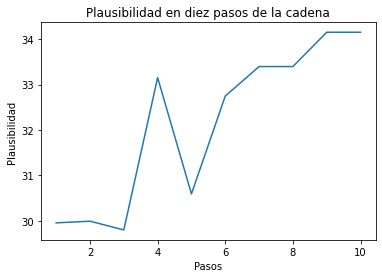

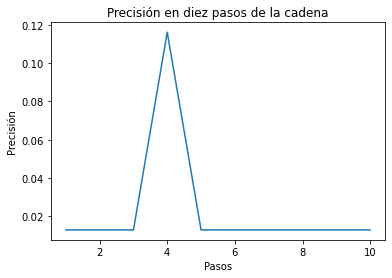

In [13]:
def graph_scores(scores, Niter, title, filename = None):
    plt.figure()
    plt.plot(np.arange(Niter) + 1, scores)
    plt.title(title)
    plt.xlabel("Pasos")
    plt.ylabel("Plausibilidad")
    plt.show()
    if filename != None:
        plt.savefig('scores/' + filename)
    return 

def graph_accuracies(accuracies, Niter, title, filename = None):
    plt.figure()
    plt.plot(np.arange(Niter) + 1, accuracies)
    plt.title(title)
    plt.xlabel("Pasos")
    plt.ylabel("Precisión")
    if filename != None:
        plt.savefig('accuracies/' + filename)
    plt.show()
graph_scores(sample_scores, 10, "Plausibilidad en diez pasos de la cadena")
graph_accuracies(sample_accuracies, 10, "Precisión en diez pasos de la cadena")

In [31]:
def save_chain(chain, scores, accuracies, filename):
    with open('chains/' + filename + '_chain.json', 'w') as f:
        json.dump(chain, f)
    with open('scores/' + filename + '_score.txt', 'w') as g:
        np.savetxt(g, scores)
    with open('accuracies/' + filename + '_accuracy.txt', 'w') as h:
        np.savetxt(h, accuracies)
    return 

Paso 0
Frase actual: SNYHBD QVBD LJDXNJD ZAJVCJ QU XJUBCBV LJ ZNDGUQSGJVCB JU YBABVJU QNAJUGQVB PNJVLGQ AJYBALB QMNJUUQ CQALJ AJSBCQ JV MNJ DN XQLAJ UB UUJFB Q YBVBYJA JU HGJUB
Plausibilidad: 30.252093053653994
Paso 1000
Frase actual: IFQMSB YUSB LOBJFOB DCOUNO YE JOESNSU LO DFBVEYIVOUNS OE QSCSUOE YFCOEVYUS ZFOULVY COQSCLS YPFOEEY NYCLO COISNY OU PFO BF JYLCO ES EEOAS Y QSUSQOC OE MVOES
Plausibilidad: 37.33934837326531
Paso 2000
Frase actual: GVWIOK ENOK PAKUVAK HZANCA ED UADOCON PA HVKTDEGTANCO AD WOZONAD EVZADTENO LVANPTE ZAWOZPO ESVADDE CEZPA ZAGOCE AN SVA KV UEPZA DO DDAQO E WONOWAZ AD ITADO
Plausibilidad: 43.14694182832078
Paso 3000
Frase actual: ZLHUON KMON JANVLAN EWAMYA KD VADOYOM JA ELNGDKZGAMYO AD HOWOMAD KLWADGKMO TLAMJGK WAHOWJO KCLADDK YKWJA WAZOYK AM CLA NL VKJWA DO DDAXO K HOMOHAW AD UGADO
Plausibilidad: 40.57997010690531
Paso 4000
Frase actual: BUMEKY ONKY RAYFUAY DZANJA OS FASKJKN RA DUYLSOBLANJK AS MKZKNAS OUZASLONK PUANRLO ZAMKZRK OQUASSO JOZRA ZABKJO AN QUA YU FORZ

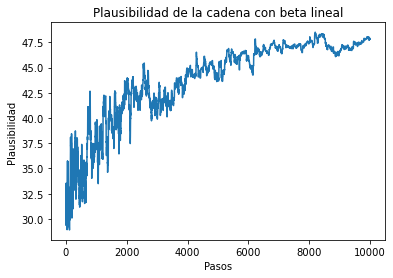

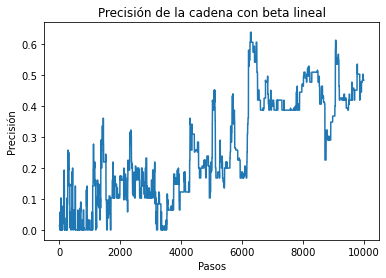

In [15]:
beta = lambda x: 10**(-3) * x
Niter = 10000
beta_lineal, scores_lineal, accuracies_lineal = SADecipher(ciphertext, Niter, beta, plaintext, print_period = 1000)
graph_scores(scores_lineal, Niter, "Plausibilidad de la cadena con beta lineal")
graph_accuracies(accuracies_lineal, Niter, "Precisión de la cadena con beta lineal")
save_chain(beta_lineal, scores_lineal, accuracies_lineal, 'testcorto_betalineal')

Paso 0
Frase actual: SYNHBQ DVBQ LJQXYJQ ZAJVCJ DU XJUBCBV LJ ZYQGUDSGJVCB JU NBABVJU DYAJUGDVB PYJVLGD AJNBALB DMYJUUD CDALJ AJSBCD JV MYJ QY XDLAJ UB UUJFB D NBVBNJA JU HGJUB
Plausibilidad: 30.216086197411926
Paso 2000
Frase actual: SOPJKV GNKV DUVTOUV FLUNBU GQ TUQKBKN DU FOVAQGSAUNBK UQ PKLKNUQ GOLUQAGNK XOUNDAG LUPKLDK GYOUQQG BGLDU LUSKBG UN YOU VO TGDLU QK QQUMK G PKNKPUL UQ JAUQK
Plausibilidad: 33.976684196007916
Paso 4000
Frase actual: UOHDEM KREM ISMWOSM QTSRLS KA WSAELER IS QOMFAKUFSRLE SA HETERSA KOTSAFKRE NOSRIFK TSHETIE KZOSAAK LKTIS TSUELK SR ZOS MO WKITS AE AASPE K HEREHST SA DFSAE
Plausibilidad: 38.962663240386604
Paso 6000
Frase actual: GUPFOY ALOY DEYIUEY JTELCE AN IENOCOL DE JUYMNAGMELCO EN POTOLEN AUTENMALO WUELDMA TEPOTDO AQUENNA CATDE TEGOCA EL QUE YU IADTE NO NNERO A POLOPET EN FMENO
Plausibilidad: 45.22427328556506
Paso 8000
Frase actual: JUZPOS ANOS TESYUES WDENME AL YELOMON TE WUSHLAJHENMO EL ZODONEL AUDELHANO GUENTHA DEZODTO AQUELLA MADTE DEJOMA EN QUE SU YA

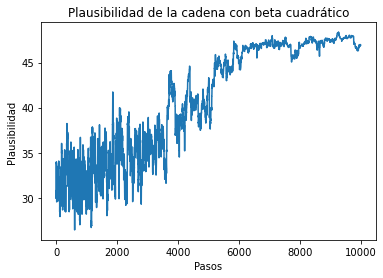

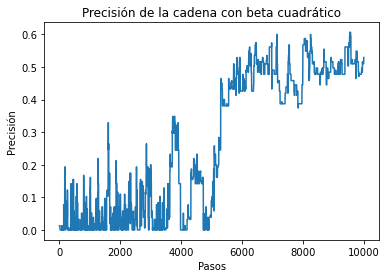

In [16]:
beta = lambda x: 10**(-7) * x ** 2
Niter = 10000
beta_quad, scores_quad, accuracies_quad = SADecipher(ciphertext, Niter, beta, plaintext, print_period = 2000)
graph_scores(scores_quad, Niter, "Plausibilidad de la cadena con beta cuadrático")
graph_accuracies(accuracies_quad, Niter, "Precisión de la cadena con beta cuadrático")
save_chain(beta_quad, scores_quad, accuracies_quad, 'testcorto_betacuadratico')

### Test con un texto más largo: Entrada de Roberto Bolaño en Wikipedia

In [34]:
def read_text(filepath: str):
    '''
    Lee y limpia un archivo de texto
    '''
    with open("bolano_wikipedia.txt", encoding="utf8") as f:
        text = f.readlines()
    for i in range(len(text)):
        text[i] = text[i].replace('\n', '')
    
    text = ' '.join(text)
    # Sólo minúsculas
    clean_text = text.casefold()

    # Eliminar tildes
    tilde_dict = {'á':'a', 'é': 'e', 'í': 'i', 'ó':'o', 'ú':'u', 'ñ': 'n'}
    for key, value in tilde_dict.items():
        clean_text = clean_text.replace(key, value)

    # Eliminar caracteres especiales
    clean_text = re.sub(r"[^a-zA-Z ]", "", clean_text)
    clean_text = clean_text.upper()
    return clean_text

test_text = read_text("bolano_wikipedia.txt")
print(test_text)
print(f"Cantidad de caracteres: {len(test_text)}")

ROBERTO BOLANO AVALOS SANTIAGO DE CHILE VEINTIOCHO DE ABRIL DE MIL NOVECIENTOS CINCUENTA Y TRES  BARCELONA QUINCE DE JULIO DE DOS MIL TRES FUE UN ESCRITOR Y POETA CHILENO AUTOR DE MAS DE DOS DECENAS DE LIBROS ENTRE LOS CUALES DESTACAN SUS NOVELAS LOS DETECTIVES SALVAJES GANADORA DEL PREMIO HERRALDE EN MIL NOVECIENTOS NOVENTA Y OCHO Y EL PREMIO ROMULO GALLEGOS EN MIL NOVECIENTOS NOVENTA Y NUEVE Y LA POSTUMA DOS MIL SEISCIENTOS SESENTA Y SEIS  DESPUES DE SU MUERTE SE HA CONVERTIDO EN UNO DE LOS ESCRITORES MAS INFLUYENTES EN LENGUA ESPANOLA COMO LO DEMUESTRAN LAS NUMEROSAS PUBLICACIONES CONSAGRADAS A SU OBRA Y EL HECHO DE QUE TRES NOVELAS ADEMAS DE LAS YA CITADAS LOS DETECTIVES SALVAJES Y DOS MIL SEISCIENTOS SESENTA Y SEIS LA BREVE ESTRELLA DISTANTE FIGUREN EN LOS QUINCE PRIMEROS LUGARES DE LA LISTA CONFECCIONADA EN DOS MIL SIETE POR OCHENTA Y UN ESCRITORES Y CRITICOS LATINOAMERICANOS Y ESPANOLES CON LOS MEJORES CIEN LIBROS EN LENGUA CASTELLANA DE LOS ULTIMOS VEINTICINCO ANOS  SU OBRA HA 

In [35]:
# Generación de una clave aleatoria
real_key = ''.join(random.sample(alphabet[1:], len(alphabet) - 1)) # El primer caracter es un espacio
print(f"Clave : {real_key}")
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(test_text, keep_punct = True)
print(ciphertext)

Clave : VDJKOXUZHNTQSYIAFMGCLPBEWR
MIDOMCI DIQVYI VPVQIG GVYCHVUI KO JZHQO POHYCHIJZI KO VDMHQ KO SHQ YIPOJHOYCIG JHYJLOYCV W CMOG  DVMJOQIYV FLHYJO KO NLQHI KO KIG SHQ CMOG XLO LY OGJMHCIM W AIOCV JZHQOYI VLCIM KO SVG KO KIG KOJOYVG KO QHDMIG OYCMO QIG JLVQOG KOGCVJVY GLG YIPOQVG QIG KOCOJCHPOG GVQPVNOG UVYVKIMV KOQ AMOSHI ZOMMVQKO OY SHQ YIPOJHOYCIG YIPOYCV W IJZI W OQ AMOSHI MISLQI UVQQOUIG OY SHQ YIPOJHOYCIG YIPOYCV W YLOPO W QV AIGCLSV KIG SHQ GOHGJHOYCIG GOGOYCV W GOHG  KOGALOG KO GL SLOMCO GO ZV JIYPOMCHKI OY LYI KO QIG OGJMHCIMOG SVG HYXQLWOYCOG OY QOYULV OGAVYIQV JISI QI KOSLOGCMVY QVG YLSOMIGVG ALDQHJVJHIYOG JIYGVUMVKVG V GL IDMV W OQ ZOJZI KO FLO CMOG YIPOQVG VKOSVG KO QVG WV JHCVKVG QIG KOCOJCHPOG GVQPVNOG W KIG SHQ GOHGJHOYCIG GOGOYCV W GOHG QV DMOPO OGCMOQQV KHGCVYCO XHULMOY OY QIG FLHYJO AMHSOMIG QLUVMOG KO QV QHGCV JIYXOJJHIYVKV OY KIG SHQ GHOCO AIM IJZOYCV W LY OGJMHCIMOG W JMHCHJIG QVCHYIVSOMHJVYIG W OGAVYIQOG JIY QIG SONIMOG JHOY QHDMIG OY QOYULV JVGCOQQVYV KO QIG LQ

Paso 0
Frase actual: JIKQJHI KINOVI OEONIM MOVHSODI YQ RLSNQ EQSVHSIRLI YQ OKJSN YQ ZSN VIEQRSQVHIM RSVRPQVHO W HJQM  KOJRQNIVO BPSVRQ YQ APNSI YQ YIM ZSN HJQM GPQ PV QMRJSHIJ W FIQHO RLSNQVI OPHIJ YQ ZOM YQ YIM YQRQVOM YQ NSKJIM QVHJQ NIM RPONQM YQMHOROV MPM VIEQNOM NIM YQHQRHSEQM MONEOAQM DOVOYIJO YQN FJQZSI LQJJONYQ QV ZSN VIEQRSQVHIM VIEQVHO W IRLI W QN FJQZSI JIZPNI DONNQDIM QV ZSN VIEQRSQVHIM VIEQVHO W VPQEQ W NO FIMHPZO YIM ZSN MQSMRSQVHIM MQMQVHO W MQSM  YQMFPQM YQ MP ZPQJHQ MQ LO RIVEQJHSYI QV PVI YQ NIM QMRJSHIJQM ZOM SVGNPWQVHQM QV NQVDPO QMFOVINO RIZI NI YQZPQMHJOV NOM VPZQJIMOM FPKNSRORSIVQM RIVMODJOYOM O MP IKJO W QN LQRLI YQ BPQ HJQM VIEQNOM OYQZOM YQ NOM WO RSHOYOM NIM YQHQRHSEQM MONEOAQM W YIM ZSN MQSMRSQVHIM MQMQVHO W MQSM NO KJQEQ QMHJQNNO YSMHOVHQ GSDPJQV QV NIM BPSVRQ FJSZQJIM NPDOJQM YQ NO NSMHO RIVGQRRSIVOYO QV YIM ZSN MSQHQ FIJ IRLQVHO W PV QMRJSHIJQM W RJSHSRIM NOHSVIOZQJSROVIM W QMFOVINQM RIV NIM ZQAIJQM RSQV NSKJIM QV NQVDPO ROMHQNNOVO YQ NIM PNHSZIM EQSVHSRS

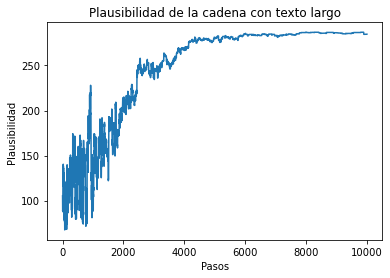

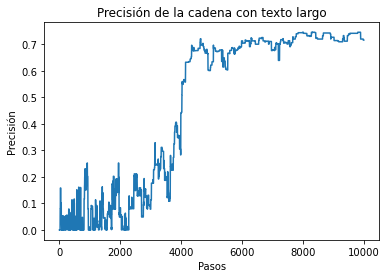

In [19]:
beta = lambda x: 5*10**(-8) * x ** 2
Niter = 10000
beta2, scores2, accuracies2 = SADecipher(ciphertext, Niter, beta, test_text, print_period = 1000)
graph_scores(scores2, Niter, "Plausibilidad de la cadena con texto largo")
graph_accuracies(accuracies2, Niter, "Precisión de la cadena con texto largo")
save_chain(beta2, scores2, accuracies2, 'testlargo_betacuadratico')

## Ataque de trigrama

In [21]:
def trig_process(word, matrix):
    '''
    Almacena la frecuencia en una palabra de cada 
    trigrama en una matriz
    
    Argumentos:
        word (string): Palabra a procesar
        matrix (pd.DataFrame): Matriz de transición
    
    Retorna:
        matrix (pd.DataFrame): Matriz de transición actualizada con
                               la palabra procesada
    '''
    letters = list(word)
    if len(word) == 1:
        matrix.loc[' ' + letters[0], ' '] = matrix.loc[' ' + letters[0], ' '] + 1
    else:
        matrix.loc[' ' + letters[0], letters[1]] = matrix.loc[' ' + letters[0], letters[1]] + 1
        for i in range(len(word)-2):
            matrix.loc[letters[i] + letters[i+1], letters[i+2]] = matrix.loc[letters[i] + letters[i+1], letters[i+2]] + 1
        matrix.loc[letters[-2] + letters[-1], ' '] = matrix.loc[letters[-2] + letters[-1], ' '] + 1
    return matrix

# Cargar el texto
with open("gloria_benitoperezgaldos.txt", encoding="utf8") as f:
    text = f.readlines()

for i in range(len(text)):
    text[i] = text[i].replace('\n', '')

text = ' '.join(text)

# Sólo minúsculas
clean_text = text.casefold()

# Eliminar tildes
tilde_dict = {'á':'a', 'é': 'e', 'í': 'i', 'ó':'o', 'ú':'u', 'ñ': 'n'}
for key, value in tilde_dict.items():
    clean_text = clean_text.replace(key, value)

# Eliminar caracteres especiales
clean_text = re.sub(r"[^a-zA-Z ]", "", clean_text)
clean_text = clean_text.upper()

trig_index = [f + s for f in list(alphabet) for s in list(alphabet[1:])]
trig_columns = alphabet
trig_matrix = pd.DataFrame(data=np.zeros((len(trig_index), len(trig_columns))), index=trig_index, columns=trig_columns)

for word in words:
    trig_matrix = trig_process(word, trig_matrix)
trig_transition = trig_matrix.apply(lambda x: x/np.sum(x), axis=1)
trig_transition = trig_transition.fillna(0)
trig_transition.to_csv("matrices/trigram.csv")

In [41]:
def trig_plausibility(ciphertext, key):
    '''
    Análogo para plausibility en el caso de ataque de trigrama
    
    Argumentos:
        ciphertext (string): Texto codificado
        key (string): Clave del mismo largo que el alfabeto a testear
        matrix (pd.DataFrame): Matriz de transición construida antes
    
    Retorna:
        plausibility (float): valor de la plausibilidad para key
    '''
    cipher = SimpleSubstitution(key)
    plaintext = cipher.decipher(ciphertext, keep_punct = True)
    words = plaintext.split()
    matrix = pd.DataFrame(data=np.zeros((len(trig_index), len(trig_columns))), 
                          index=trig_index, columns=trig_columns)
    for word in words:
        matrix = trig_process(word, matrix)
    plausibility = np.sum((1 + matrix.to_numpy()) * np.log(1 + trig_transition.to_numpy()))
    return plausibility

plaintext = "MUCHOS ANOS DESPUES FRENTE AL PELOTON DE FUSILAMIENTO " + \
            "EL CORONEL AURELIANO BUENDIA RECORDO AQUELLA TARDE REMOTA " + \
            "EN QUE SU PADRE LO LLEVO A CONOCER EL HIELO"
real_key = "AJPCZWRLFBDKOTYUQGENHXMIVS"
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(plaintext, keep_punct = True)
print(f"Texto cifrado: {ciphertext}")
print(f"Plausibilidad: {trig_plausibility(ciphertext, real_key)}")

Texto cifrado: OHPLYE ATYE CZEUHZE WGZTNZ AK UZKYNYT CZ WHEFKAOFZTNY ZK PYGYTZK AHGZKFATY JHZTCFA GZPYGCY AQHZKKA NAGCZ GZOYNA ZT QHZ EH UACGZ KY KKZXY A PYTYPZG ZK LFZKY
Plausibilidad: 360.2604717419199


Paso 0
Frase actual: SNYHBQ DVBQ LJQXNJQ ZAJVCJ DU XJUBCBV LJ ZNQGUDSGJVCB JU YBABVJU DNAJUGDVB PNJVLGD AJYBALB DMNJUUD CDALJ AJSBCD JV MNJ QN XDLAJ UB UUJFB D YBVBYJA JU HGJUB
Plausibilidad: 334.11227886912826
Paso 1000
Frase actual: CDJQAM LXAM ROMGDOM YNOXIO LE GOEAIAX RO YDMSELCSOXIA OE JANAXOE LDNOESLXA TDOXRSL NOJANRA LFDOEEL ILNRO NOCAIL OX FDO MD GLRNO EA EEOBA L JAXAJON OE QSOEA
Plausibilidad: 343.18931378950805
Paso 2000
Frase actual: HUPBOS NROS TASCUAS WZARIA NY CAYOIOR TA WUSVYNHVARIO AY POZORAY NUZAYVNRO DUARTVN ZAPOZTO NJUAYYN INZTA ZAHOIN AR JUA SU CNTZA YO YYAEO N POROPAZ AY BVAYO
Plausibilidad: 349.51869424878157
Paso 3000
Frase actual: HUMZOS ADOS RESVUES BTEDPE AN VENOPOD RE BUSINAHIEDPO EN MOTODEN AUTENIADO FUEDRIA TEMOTRO AQUENNA PATRE TEHOPA ED QUE SU VARTE NO NNEJO A MODOMET EN ZIENO
Plausibilidad: 356.63956872347364
Paso 4000
Frase actual: HUPKOS ANOS DESCUES QRENJE AL CELOJON DE QUSILAHIENJO EL PORONEL AURELIANO VUENDIA REPORDO AFUELLA JARDE REHOJA EN FUE SU C

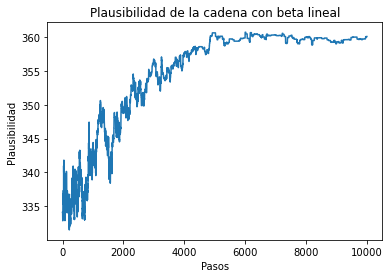

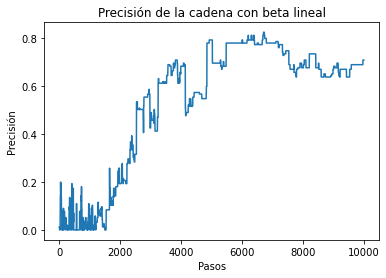

Paso 0
Frase actual: SNYHBQ DVBQ LJQXNJQ ZAJVFJ DU XJUBFBV LJ ZNQGUDSGJVFB JU YBABVJU DNAJUGDVB PNJVLGD AJYBALB DMNJUUD FDALJ AJSBFD JV MNJ QN XDLAJ UB UUJCB D YBVBYJA JU HGJUB
Plausibilidad: 334.11227886912826
Paso 2000
Frase actual: COJGFL XNFL VALWOAL RDANUA XI WAIFUFN VA ROLTIXCTANUF AI JFDFNAI XODAITXNF POANVTX DAJFDVF XMOAIIX UXDVA DACFUX AN MOA LO WXVDA IF IIAHF X JFNFJAD AI GTAIF
Plausibilidad: 338.0811613931823
Paso 4000
Frase actual: NRTJOP AHOP UEPVREP BWEHDE AL VELODOH UE BRPYLANYEHDO EL TOWOHEL ARWELYAHO XREHUYA WETOWUO AFRELLA DAWUE WENODA EH FRE PR VAUWE LO LLESO A TOHOTEW EL JYELO
Plausibilidad: 347.2892445902031
Paso 6000
Frase actual: JUCFOS AZOS DESBUES GREZLE AN BENOLOZ DE GUSINAJIEZLO EN COROZEN AURENIAZO QUEZDIA RECORDO APUENNA LARDE REJOLA EZ PUE SU BADRE NO NNEKO A COZOCER EN FIENO
Plausibilidad: 357.48134152013574
Paso 8000
Frase actual: JUPKOS AZOS DESVUES LREZTE AN VENOTOZ DE LUSINAJIEZTO EN POROZEN AURENIAZO BUEZDIA REPORDO AQUENNA TARDE REJOTA EZ QUE SU VAD

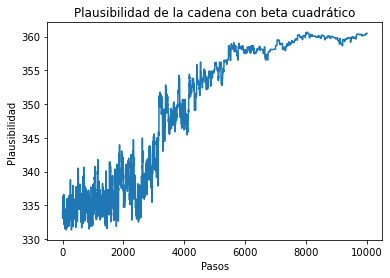

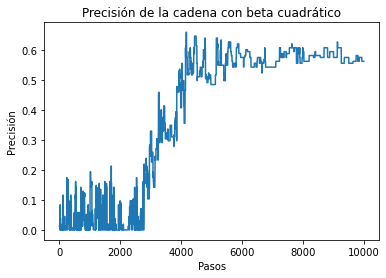

In [23]:
beta = lambda x: 10**(-3) * x
Niter = 10000
beta_lineal, scores_lineal, accuracies_lineal = SADecipher(ciphertext, Niter, beta, plaintext, 
                                                           print_period = 1000, plaus_fun = trig_plausibility)
graph_scores(scores_lineal, Niter, "Plausibilidad de la cadena con beta lineal")
graph_accuracies(accuracies_lineal, Niter, "Precisión de la cadena con beta lineal")
save_chain(beta_lineal, scores_lineal, accuracies_lineal, 'testcorto_trigrama_betalineal')

beta = lambda x: 10**(-7) * x ** 2
Niter = 10000
beta_quad, scores_quad, accuracies_quad = SADecipher(ciphertext, Niter, beta, plaintext, 
                                                     print_period = 2000, plaus_fun = trig_plausibility)
graph_scores(scores_quad, Niter, "Plausibilidad de la cadena con beta cuadrático")
graph_accuracies(accuracies_quad, Niter, "Precisión de la cadena con beta cuadrático")
save_chain(beta_quad, scores_quad, accuracies_quad, 'testcorto_trigrama_betacuadratico')

Clave : MSVOXTARYLGZNCJHBUIFQEDKPW
UJSXUFJ SJZMCJ MEMZJI IMCFYMAJ OX VRYZX EXYCFYJVRJ OX MSUYZ OX NYZ CJEXVYXCFJI VYCVQXCFM P FUXI  SMUVXZJCM BQYCVX OX LQZYJ OX OJI NYZ FUXI TQX QC XIVUYFJU P HJXFM VRYZXCJ MQFJU OX NMI OX OJI OXVXCMI OX ZYSUJI XCFUX ZJI VQMZXI OXIFMVMC IQI CJEXZMI ZJI OXFXVFYEXI IMZEMLXI AMCMOJUM OXZ HUXNYJ RXUUMZOX XC NYZ CJEXVYXCFJI CJEXCFM P JVRJ P XZ HUXNYJ UJNQZJ AMZZXAJI XC NYZ CJEXVYXCFJI CJEXCFM P CQXEX P ZM HJIFQNM OJI NYZ IXYIVYXCFJI IXIXCFM P IXYI  OXIHQXI OX IQ NQXUFX IX RM VJCEXUFYOJ XC QCJ OX ZJI XIVUYFJUXI NMI YCTZQPXCFXI XC ZXCAQM XIHMCJZM VJNJ ZJ OXNQXIFUMC ZMI CQNXUJIMI HQSZYVMVYJCXI VJCIMAUMOMI M IQ JSUM P XZ RXVRJ OX BQX FUXI CJEXZMI MOXNMI OX ZMI PM VYFMOMI ZJI OXFXVFYEXI IMZEMLXI P OJI NYZ IXYIVYXCFJI IXIXCFM P IXYI ZM SUXEX XIFUXZZM OYIFMCFX TYAQUXC XC ZJI BQYCVX HUYNXUJI ZQAMUXI OX ZM ZYIFM VJCTXVVYJCMOM XC OJI NYZ IYXFX HJU JVRXCFM P QC XIVUYFJUXI P VUYFYVJI ZMFYCJMNXUYVMCJI P XIHMCJZXI VJC ZJI NXLJUXI VYXC ZYSUJI XC ZXCAQM VMIFXZZMCM OX ZJI QZ

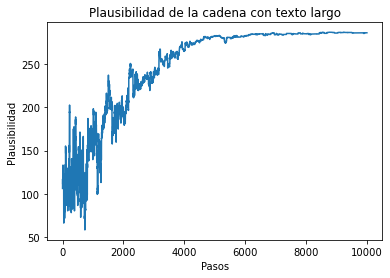

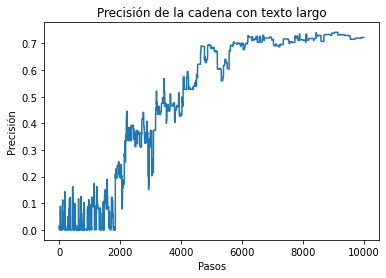

In [24]:
test_text = read_text("bolano_wikipedia.txt")
# Generación de una clave aleatoria
real_key = ''.join(random.sample(alphabet[1:], len(alphabet) - 1)) # El primer caracter es un espacio
print(f"Clave : {real_key}")
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(test_text, keep_punct = True)
print(ciphertext)
print(f"(Tri-)Plausibilidad de la clave real: {trig_plausibility(ciphertext, real_key)}")

beta = lambda x: 5*10**(-8) * x ** 2
Niter = 10000
beta2, scores2, accuracies2 = SADecipher(ciphertext, Niter, beta, test_text, print_period = 1000)
graph_scores(scores2, Niter, "Plausibilidad de la cadena con texto largo")
graph_accuracies(accuracies2, Niter, "Precisión de la cadena con texto largo")
save_chain(beta2, scores2, accuracies2, 'testlargo_trigrama_betacuadratico')

## Intentos con distintas condiciones iniciales

In [25]:
beta = lambda x: 10**(-7) * x ** 2
Niter = 10000

plaintext = "MUCHOS ANOS DESPUES FRENTE AL PELOTON DE FUSILAMIENTO " + \
            "EL CORONEL AURELIANO BUENDIA RECORDO AQUELLA TARDE REMOTA " + \
            "EN QUE SU PADRE LO LLEVO A CONOCER EL HIELO"
real_key = "AJPCZWRLFBDKOTYUQGENHXMIVS"
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(plaintext, keep_punct = True)

In [27]:
## Ataque de bigrama, beta cuadrático, texto corto
incumbent_plaus = 0
incumbent_key = ""
for i in range(20):
    chain, scores, accuracies = SADecipher(ciphertext, Niter, beta, plaintext)
    max_index = np.argmax(scores)
    if scores[max_index] > incumbent_plaus:
        incumbent_plaus = scores[max_index]
        incumbent_key = chain[max_index]
    save_chain(chain, scores, accuracies, f'testcorto_bigrama_{i+1}')
best_key_bigram_short = incumbent_key

In [28]:
## Ataque de trigrama, beta cuadrático, texto corto
incumbent_plaus = 0
incumbent_key = ""
for i in range(20):
    chain, scores, accuracies = SADecipher(ciphertext, Niter, beta, plaintext, 
                                            plaus_fun = trig_plausibility)
    max_index = np.argmax(scores)
    if scores[max_index] > incumbent_plaus:
        incumbent_plaus = scores[max_index]
        incumbent_key = chain[max_index]
    save_chain(chain, scores, accuracies, f'testcorto_trigrama_{i+1}')
best_key_trigram_short = incumbent_key

In [29]:
# Test largo
plaintext = read_text("bolano_wikipedia.txt")
# Generación de una clave aleatoria
real_key = ''.join(random.sample(alphabet[1:], len(alphabet) - 1)) # El primer caracter es un espacio
print(f"Clave : {real_key}")
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(plaintext, keep_punct = True)
print(ciphertext)
print(f"(Tri-)Plausibilidad de la clave real: {trig_plausibility(ciphertext, real_key)}")

Clave : IMQZKOJXCNHSGEVUWAFBDLRYTP
AVMKABV MVSIEV ILISVF FIEBCIJV ZK QXCSK LKCEBCVQXV ZK IMACS ZK GCS EVLKQCKEBVF QCEQDKEBI T BAKF  MIAQKSVEI WDCEQK ZK NDSCV ZK ZVF GCS BAKF ODK DE KFQACBVA T UVKBI QXCSKEV IDBVA ZK GIF ZK ZVF ZKQKEIF ZK SCMAVF KEBAK SVF QDISKF ZKFBIQIE FDF EVLKSIF SVF ZKBKQBCLKF FISLINKF JIEIZVAI ZKS UAKGCV XKAAISZK KE GCS EVLKQCKEBVF EVLKEBI T VQXV T KS UAKGCV AVGDSV JISSKJVF KE GCS EVLKQCKEBVF EVLKEBI T EDKLK T SI UVFBDGI ZVF GCS FKCFQCKEBVF FKFKEBI T FKCF  ZKFUDKF ZK FD GDKABK FK XI QVELKABCZV KE DEV ZK SVF KFQACBVAKF GIF CEOSDTKEBKF KE SKEJDI KFUIEVSI QVGV SV ZKGDKFBAIE SIF EDGKAVFIF UDMSCQIQCVEKF QVEFIJAIZIF I FD VMAI T KS XKQXV ZK WDK BAKF EVLKSIF IZKGIF ZK SIF TI QCBIZIF SVF ZKBKQBCLKF FISLINKF T ZVF GCS FKCFQCKEBVF FKFKEBI T FKCF SI MAKLK KFBAKSSI ZCFBIEBK OCJDAKE KE SVF WDCEQK UACGKAVF SDJIAKF ZK SI SCFBI QVEOKQQCVEIZI KE ZVF GCS FCKBK UVA VQXKEBI T DE KFQACBVAKF T QACBCQVF SIBCEVIGKACQIEVF T KFUIEVSKF QVE SVF GKNVAKF QCKE SCMAVF KE SKEJDI QIFBKSSIEI ZK SVF DS

In [30]:
## Ataque de bigrama, beta cuadrático, texto largo
incumbent_plaus = 0
incumbent_key = ""
for i in range(20):
    chain, scores, accuracies = SADecipher(ciphertext, Niter, beta, plaintext)
    max_index = np.argmax(scores)
    if scores[max_index] > incumbent_plaus:
        incumbent_plaus = scores[max_index]
        incumbent_key = chain[max_index]
    save_chain(chain, scores, accuracies, f'testlargo_bigrama_{i+1}')
best_key_bigram_long = incumbent_key

In [31]:
## Ataque de trigrama, beta cuadrático, texto largo
incumbent_plaus = 0
incumbent_key = ""
for i in range(20):
    chain, scores, accuracies = SADecipher(ciphertext, Niter, beta, plaintext, 
                                            plaus_fun = trig_plausibility)
    max_index = np.argmax(scores)
    if scores[max_index] > incumbent_plaus:
        incumbent_plaus = scores[max_index]
        incumbent_key = chain[max_index]
    save_chain(chain, scores, accuracies, f'testlargo_trigrama_{i+1}')
best_key_trigram_long = incumbent_key

In [33]:
with open('testlargo.key', 'w') as f:
    json.dump(real_key, f)

## Comparación de la mejor clave entre los distintos métodos 

In [42]:
## Test con texto largo

plaintext = read_text("bolano_wikipedia.txt")
# Lectura de la clave
with open("testlargo.key", "r") as f:
    real_key = json.load(f)
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(plaintext, keep_punct = True)
    
methods = ['bigrama', 'trigrama']
metrics = ['plausibility', 'accuracy']
longtest_performance = pd.DataFrame(index = methods, columns = metrics)
longtest_performance['plausibility'] = [plausibility(ciphertext, best_key_bigram_long),
                                   trig_plausibility(ciphertext, best_key_trigram_long)]
longtest_performance['accuracy'] = [accuracy(plaintext, ciphertext, best_key_bigram_long),
                                   accuracy(plaintext, ciphertext, best_key_trigram_long)]
longtest_performance

,plausibility,accuracy
bigrama,286.877562,0.745714
trigrama,649.325318,0.833714


In [40]:
best_key_bigram_cipher = SimpleSubstitution(best_key_bigram_long)
print("Texto obtenido por el ataque de bigrama")
best_key_bigram_cipher.decipher(ciphertext, keep_punct=True)

Texto obtenido por el ataque de bigrama


'ROBERTO BOLANO AVALOK KANTIAGO DE CHILE VEINTIOCHO DE ABRIL DE MIL NOVECIENTOK CINCUENTA Y TREK  BARCELONA QUINCE DE JULIO DE DOK MIL TREK FUE UN EKCRITOR Y POETA CHILENO AUTOR DE MAK DE DOK DECENAK DE LIBROK ENTRE LOK CUALEK DEKTACAN KUK NOVELAK LOK DETECTIVEK KALVAJEK GANADORA DEL PREMIO HERRALDE EN MIL NOVECIENTOK NOVENTA Y OCHO Y EL PREMIO ROMULO GALLEGOK EN MIL NOVECIENTOK NOVENTA Y NUEVE Y LA POKTUMA DOK MIL KEIKCIENTOK KEKENTA Y KEIK  DEKPUEK DE KU MUERTE KE HA CONVERTIDO EN UNO DE LOK EKCRITOREK MAK INFLUYENTEK EN LENGUA EKPANOLA COMO LO DEMUEKTRAN LAK NUMEROKAK PUBLICACIONEK CONKAGRADAK A KU OBRA Y EL HECHO DE QUE TREK NOVELAK ADEMAK DE LAK YA CITADAK LOK DETECTIVEK KALVAJEK Y DOK MIL KEIKCIENTOK KEKENTA Y KEIK LA BREVE EKTRELLA DIKTANTE FIGUREN EN LOK QUINCE PRIMEROK LUGAREK DE LA LIKTA CONFECCIONADA EN DOK MIL KIETE POR OCHENTA Y UN EKCRITOREK Y CRITICOK LATINOAMERICANOK Y EKPANOLEK CON LOK MEJOREK CIEN LIBROK EN LENGUA CAKTELLANA DE LOK ULTIMOK VEINTICINCO ANOK  KU OBRA HA

In [41]:
best_key_trigram_cipher = SimpleSubstitution(best_key_trigram_long)
print("Texto obtenido por el ataque de trigrama")
best_key_trigram_cipher.decipher(ciphertext, keep_punct=True)

Texto obtenido por el ataque de trigrama


'ROBERTO BOLANO AVALOS SANTIAGO DE CHILE VEINTIOCHO DE ABRIL DE MIL NOVECIENTOS CINCUENTA Y TRES  BARCELONA QUINCE DE JULIO DE DOS MIL TRES FUE UN ESCRITOR Y POETA CHILENO AUTOR DE MAS DE DOS DECENAS DE LIBROS ENTRE LOS CUALES DESTACAN SUS NOVELAS LOS DETECTIVES SALVAJES GANADORA DEL PREMIO HERRALDE EN MIL NOVECIENTOS NOVENTA Y OCHO Y EL PREMIO ROMULO GALLEGOS EN MIL NOVECIENTOS NOVENTA Y NUEVE Y LA POSTUMA DOS MIL SEISCIENTOS SESENTA Y SEIS  DESPUES DE SU MUERTE SE HA CONVERTIDO EN UNO DE LOS ESCRITORES MAS INFLUYENTES EN LENGUA ESPANOLA COMO LO DEMUESTRAN LAS NUMEROSAS PUBLICACIONES CONSAGRADAS A SU OBRA Y EL HECHO DE QUE TRES NOVELAS ADEMAS DE LAS YA CITADAS LOS DETECTIVES SALVAJES Y DOS MIL SEISCIENTOS SESENTA Y SEIS LA BREVE ESTRELLA DISTANTE FIGUREN EN LOS QUINCE PRIMEROS LUGARES DE LA LISTA CONFECCIONADA EN DOS MIL SIETE POR OCHENTA Y UN ESCRITORES Y CRITICOS LATINOAMERICANOS Y ESPANOLES CON LOS MEJORES CIEN LIBROS EN LENGUA CASTELLANA DE LOS ULTIMOS VEINTICINCO ANOS  SU OBRA HA

In [43]:
## Test con texto corto
plaintext = "MUCHOS ANOS DESPUES FRENTE AL PELOTON DE FUSILAMIENTO " + \
            "EL CORONEL AURELIANO BUENDIA RECORDO AQUELLA TARDE REMOTA " + \
            "EN QUE SU PADRE LO LLEVO A CONOCER EL HIELO"
real_key = "AJPCZWRLFBDKOTYUQGENHXMIVS"
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(plaintext, keep_punct = True)

shorttest_performance = pd.DataFrame(index = methods, columns = metrics)
shorttest_performance['plausibility'] = [plausibility(ciphertext, best_key_bigram_short),
                                   trig_plausibility(ciphertext, best_key_trigram_short)]
shorttest_performance['accuracy'] = [accuracy(plaintext, ciphertext, best_key_bigram_short),
                                   accuracy(plaintext, ciphertext, best_key_trigram_short)]
shorttest_performance

,plausibility,accuracy
bigrama,48.433387,0.477419
trigrama,360.911230,0.761290


In [44]:
best_key_bigram_cipher = SimpleSubstitution(best_key_bigram_short)
print("Texto obtenido por el ataque de bigrama")
best_key_bigram_cipher.decipher(ciphertext, keep_punct=True)

Texto obtenido por el ataque de bigrama


'CUJMOK ANOK VEKTUEK PDENHE AS TESOHON VE PUKISACIENHO ES JODONES AUDESIANO YUENVIA DEJODVO AQUESSA HADVE DECOHA EN QUE KU TAVDE SO SSELO A JONOJED ES MIESO'

In [45]:
best_key_trigram_cipher = SimpleSubstitution(best_key_trigram_short)
print("Texto obtenido por el ataque de trigrama")
best_key_trigram_cipher.decipher(ciphertext, keep_punct=True)

Texto obtenido por el ataque de trigrama


'BUCHOS ANOS DESPUES ZRENTE AL PELOTON DE ZUSYLABYENTO EL CORONEL AURELYANO FUENDYA RECORDO AQUELLA TARDE REBOTA EN QUE SU PADRE LO LLEJO A CONOCER EL HYELO'

## Benchmark: Stochastic Hill Climbing

In [28]:
def HCDecipher(ciphertext: str, Niter: int, plaintext,
               initial_key = random.sample(alphabet[1:], len(alphabet) - 1),
               print_period = None, plaus_fun = plausibility):
    '''
    Función que implementa Hill Climbing 
    para el problema de descifrado
    
    Argumentos:
        ciphertext: Código a descifrar
        Niter: Número de pasos a realizar
        initial_key (str): una clave inicial para el algoritmo
        print_period: Representa el periodo de actualización. 
            Si no es None, se imprime el estado de la cadena
            y la plausibilidad cada print_period pasos
    
    Retorna:
        key: Estado de la cadena luego de Niter pasos
    '''
    key = initial_key
    incumbent_plaus = plaus_fun(ciphertext, key)
    incumbent_accuracy = accuracy(plaintext, ciphertext, key)
    keys = [[] for i in range(Niter)]
    scores = np.zeros(Niter)
    accuracies = np.zeros(Niter)        
    if print_period == None:
        for i in range(Niter):
            keys[i] = key
            scores[i] = incumbent_plaus
            accuracies[i] = incumbent_accuracy
            new_key = neighbor(key)
            new_plaus = plaus_fun(ciphertext, new_key)
            if new_plaus >= incumbent_plaus:
                key = new_key
                incumbent_plaus = new_plaus
                incumbent_accuracy = accuracy(plaintext, ciphertext, key)

    else:
        for i in range(Niter):
            keys[i] = key
            scores[i] = incumbent_plaus
            accuracies[i] = incumbent_accuracy
            new_key = neighbor(key)
            new_plaus = plaus_fun(ciphertext, new_key)
            if new_plaus >= incumbent_plaus:
                key = new_key
                incumbent_plaus = new_plaus
                incumbent_accuracy = accuracy(plaintext, ciphertext, key)
            if i % print_period == 0:
                cipher = SimpleSubstitution(key)
                print(f"Paso {i}")
                print(f"Frase actual: {cipher.decipher(ciphertext, keep_punct = True)}")
                print(f"Plausibilidad: {incumbent_plaus}")
    return keys, scores, accuracies

# Test de HCDecipher    
sample_advance, sample_scores, sample_accuracies = HCDecipher(ciphertext, 10, plaintext)
print(f"Estado de la cadena luego de 10 pasos con beta = 1: {sample_advance[-1]}")
print(f"Indices intercambiados: {[i for i in range(len(example_key)) if 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'[i] != sample_advance[-1][i]]}")

Estado de la cadena luego de 10 pasos con beta = 1: ASGMCBURHWDFEQLZVKINTOYPJX
Indices intercambiados: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


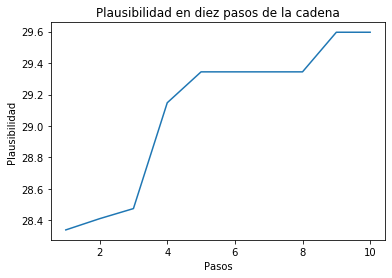

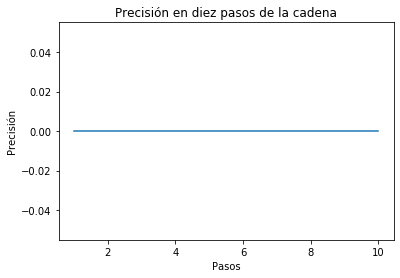

In [26]:
def graph_scores(scores, Niter, title, filename = None):
    plt.figure()
    plt.plot(np.arange(Niter) + 1, scores)
    plt.title(title)
    plt.xlabel("Pasos")
    plt.ylabel("Plausibilidad")
    plt.show()
    if filename != None:
        plt.savefig('scores/' + filename)
    return 

def graph_accuracies(accuracies, Niter, title, filename = None):
    plt.figure()
    plt.plot(np.arange(Niter) + 1, accuracies)
    plt.title(title)
    plt.xlabel("Pasos")
    plt.ylabel("Precisión")
    if filename != None:
        plt.savefig('accuracies/' + filename)
    plt.show()
graph_scores(sample_scores, 10, "Plausibilidad en diez pasos de la cadena")
graph_accuracies(sample_accuracies, 10, "Precisión en diez pasos de la cadena")

Paso 0
Frase actual: GFXOWM AUWM EPMVFPM JCPUHP AR VPRWHWU EP JFMLRAGLPUHW PR XWCWUPR AFCPRLAUW YFPUELA CPXWCEW ANFPRRA HACEP CPGWHA PU NFP MF VAECP RW RRPZW A XWUWXPC PR OLPRW
Plausibilidad: 32.94903109610149
Paso 1000
Frase actual: DEJLOS AIOS CKSTEKS UNKIZK AY TKYOZOI CK UESHYADHKIZO KY JONOIKY AENKYHAIO MEKICHA NKJONCO AVEKYYA ZANCK NKDOZA KI VEK SE TACNK YO YYKPO A JOIOJKN KY LHKYO
Plausibilidad: 44.479571212448235
Paso 2000
Frase actual: DECIOS KNOS HASTEAS PLANJA KY TAYOJON HA PESZYKDZANJO AY COLONAY KELAYZKNO UEANHZK LACOLHO KVEAYYK JKLHA LADOJK AN VEA SE TKHLA YO YYAMO K CONOCAL AY IZAYO
Plausibilidad: 46.555759223163676
Paso 3000
Frase actual: PECIOS KNOS HASTEAS DZANJA KY TAYOJON HA DESLYKPLANJO AY COZONAY KEZAYLKNO UEANHLK ZACOZHO KVEAYYK JKZHA ZAPOJK AN VEA SE TKHZA YO YYAMO K CONOCAZ AY ILAYO
Plausibilidad: 46.57858580356378
Paso 4000
Frase actual: PECIOS KNOS HASTEAS DZANJA KY TAYOJON HA DESLYKPLANJO AY COZONAY KEZAYLKNO UEANHLK ZACOZHO KVEAYYK JKZHA ZAPOJK AN VEA SE TKH

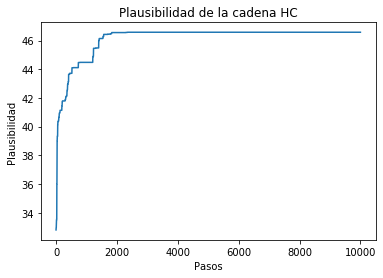

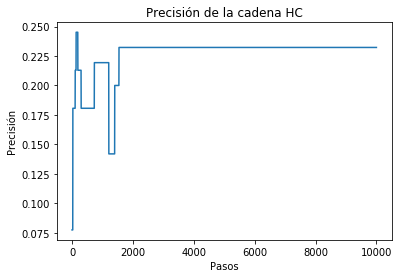

NameError: name 'save_chain' is not defined

In [30]:
Niter = 10000
HC, scores, accuracies = HCDecipher(ciphertext, Niter, plaintext, print_period = 1000)
graph_scores(scores_lineal, Niter, "Plausibilidad de la cadena HC")
graph_accuracies(accuracies_lineal, Niter, "Precisión de la cadena HC")

In [32]:
save_chain(HC, scores, accuracies, 'testcorto_HC')

## Text Largo Hill Climbing

In [36]:
test_text = read_text("bolano_wikipedia.txt")
print(test_text)
print(f"Cantidad de caracteres: {len(test_text)}")

ROBERTO BOLANO AVALOS SANTIAGO DE CHILE VEINTIOCHO DE ABRIL DE MIL NOVECIENTOS CINCUENTA Y TRES  BARCELONA QUINCE DE JULIO DE DOS MIL TRES FUE UN ESCRITOR Y POETA CHILENO AUTOR DE MAS DE DOS DECENAS DE LIBROS ENTRE LOS CUALES DESTACAN SUS NOVELAS LOS DETECTIVES SALVAJES GANADORA DEL PREMIO HERRALDE EN MIL NOVECIENTOS NOVENTA Y OCHO Y EL PREMIO ROMULO GALLEGOS EN MIL NOVECIENTOS NOVENTA Y NUEVE Y LA POSTUMA DOS MIL SEISCIENTOS SESENTA Y SEIS  DESPUES DE SU MUERTE SE HA CONVERTIDO EN UNO DE LOS ESCRITORES MAS INFLUYENTES EN LENGUA ESPANOLA COMO LO DEMUESTRAN LAS NUMEROSAS PUBLICACIONES CONSAGRADAS A SU OBRA Y EL HECHO DE QUE TRES NOVELAS ADEMAS DE LAS YA CITADAS LOS DETECTIVES SALVAJES Y DOS MIL SEISCIENTOS SESENTA Y SEIS LA BREVE ESTRELLA DISTANTE FIGUREN EN LOS QUINCE PRIMEROS LUGARES DE LA LISTA CONFECCIONADA EN DOS MIL SIETE POR OCHENTA Y UN ESCRITORES Y CRITICOS LATINOAMERICANOS Y ESPANOLES CON LOS MEJORES CIEN LIBROS EN LENGUA CASTELLANA DE LOS ULTIMOS VEINTICINCO ANOS  SU OBRA HA 

In [37]:
# Generación de una clave aleatoria
real_key = ''.join(random.sample(alphabet[1:], len(alphabet) - 1)) # El primer caracter es un espacio
print(f"Clave : {real_key}")
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(test_text, keep_punct = True)
print(ciphertext)

Clave : QGRMZCNKYWXAHVLFSUODIEPTJB
ULGZUDL GLAQVL QEQALO OQVDYQNL MZ RKYAZ EZYVDYLRKL MZ QGUYA MZ HYA VLEZRYZVDLO RYVRIZVDQ J DUZO  GQURZALVQ SIYVRZ MZ WIAYL MZ MLO HYA DUZO CIZ IV ZORUYDLU J FLZDQ RKYAZVL QIDLU MZ HQO MZ MLO MZRZVQO MZ AYGULO ZVDUZ ALO RIQAZO MZODQRQV OIO VLEZAQO ALO MZDZRDYEZO OQAEQWZO NQVQMLUQ MZA FUZHYL KZUUQAMZ ZV HYA VLEZRYZVDLO VLEZVDQ J LRKL J ZA FUZHYL ULHIAL NQAAZNLO ZV HYA VLEZRYZVDLO VLEZVDQ J VIZEZ J AQ FLODIHQ MLO HYA OZYORYZVDLO OZOZVDQ J OZYO  MZOFIZO MZ OI HIZUDZ OZ KQ RLVEZUDYML ZV IVL MZ ALO ZORUYDLUZO HQO YVCAIJZVDZO ZV AZVNIQ ZOFQVLAQ RLHL AL MZHIZODUQV AQO VIHZULOQO FIGAYRQRYLVZO RLVOQNUQMQO Q OI LGUQ J ZA KZRKL MZ SIZ DUZO VLEZAQO QMZHQO MZ AQO JQ RYDQMQO ALO MZDZRDYEZO OQAEQWZO J MLO HYA OZYORYZVDLO OZOZVDQ J OZYO AQ GUZEZ ZODUZAAQ MYODQVDZ CYNIUZV ZV ALO SIYVRZ FUYHZULO AINQUZO MZ AQ AYODQ RLVCZRRYLVQMQ ZV MLO HYA OYZDZ FLU LRKZVDQ J IV ZORUYDLUZO J RUYDYRLO AQDYVLQHZUYRQVLO J ZOFQVLAZO RLV ALO HZWLUZO RYZV AYGULO ZV AZVNIQ RQODZAAQVQ MZ ALO IA

In [38]:
HC2, scoresHC2, accuraciesHC2 = HCDecipher(ciphertext, Niter, test_text, print_period = 1000)
graph_scores(scoresHC2, Niter, "Plausibilidad de la cadena con texto largo")
graph_accuracies(accuraciesHC2, Niter, "Precisión de la cadena con texto largo")

Paso 0
Frase actual: GOCPGKO COANQO NMNAOV VNQKUNHO DP TRUAP MPUQKUOTRO DP NCGUA DP FUA QOMPTUPQKOV TUQTSPQKN Y KGPV  CNGTPAOQN BSUQTP DP JSAUO DP DOV FUA KGPV ESP SQ PVTGUKOG Y LOPKN TRUAPQO NSKOG DP FNV DP DOV DPTPQNV DP AUCGOV PQKGP AOV TSNAPV DPVKNTNQ VSV QOMPANV AOV DPKPTKUMPV VNAMNJPV HNQNDOGN DPA LGPFUO RPGGNADP PQ FUA QOMPTUPQKOV QOMPQKN Y OTRO Y PA LGPFUO GOFSAO HNAAPHOV PQ FUA QOMPTUPQKOV QOMPQKN Y QSPMP Y AN LOVKSFN DOV FUA VPUVTUPQKOV VPVPQKN Y VPUV  DPVLSPV DP VS FSPGKP VP RN TOQMPGKUDO PQ SQO DP AOV PVTGUKOGPV FNV UQEASYPQKPV PQ APQHSN PVLNQOAN TOFO AO DPFSPVKGNQ ANV QSFPGOVNV LSCAUTNTUOQPV TOQVNHGNDNV N VS OCGN Y PA RPTRO DP BSP KGPV QOMPANV NDPFNV DP ANV YN TUKNDNV AOV DPKPTKUMPV VNAMNJPV Y DOV FUA VPUVTUPQKOV VPVPQKN Y VPUV AN CGPMP PVKGPAAN DUVKNQKP EUHSGPQ PQ AOV BSUQTP LGUFPGOV ASHNGPV DP AN AUVKN TOQEPTTUOQNDN PQ DOV FUA VUPKP LOG OTRPQKN Y SQ PVTGUKOGPV Y TGUKUTOV ANKUQONFPGUTNQOV Y PVLNQOAPV TOQ AOV FPJOGPV TUPQ AUCGOV PQ APQHSN TNVKPAANQN DP AOV SAKUFOV MPUQKUTU

NameError: name 'scores2' is not defined

In [40]:
save_chain(HC2, scoresHC2, accuraciesHC2, 'testlargo_HC')

## Trigrama Atack Hill Climbing

In [42]:
plaintext = "MUCHOS ANOS DESPUES FRENTE AL PELOTON DE FUSILAMIENTO " + \
            "EL CORONEL AURELIANO BUENDIA RECORDO AQUELLA TARDE REMOTA " + \
            "EN QUE SU PADRE LO LLEVO A CONOCER EL HIELO"
real_key = "AJPCZWRLFBDKOTYUQGENHXMIVS"
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(plaintext, keep_punct = True)
print(f"Texto cifrado: {ciphertext}")
print(f"Plausibilidad: {trig_plausibility(ciphertext, real_key)}")

Texto cifrado: OHPLYE ATYE CZEUHZE WGZTNZ AK UZKYNYT CZ WHEFKAOFZTNY ZK PYGYTZK AHGZKFATY JHZTCFA GZPYGCY AQHZKKA NAGCZ GZOYNA ZT QHZ EH UACGZ KY KKZXY A PYTYPZG ZK LFZKY
Plausibilidad: 360.2604717419199


### Text Corto

Paso 0
Frase actual: VFXOWM AUWM EPMGFPM JCPUHP AR GPRWHWU EP JFMLRAVLPUHW PR XWCWUPR AFCPRLAUW YFPUELA CPXWCEW ANFPRRA HACEP CPVWHA PU NFP MF GAECP RW RRPZW A XWUWXPC PR OLPRW
Plausibilidad: 335.42321824528005
Paso 1000
Frase actual: FRIGUE AYUE DOETROE ZNOYMO AS TOSUMUY DO ZRELSAFLOYMU OS IUNUYOS ARNOSLAYU JROYDLA NOIUNDU APROSSA MANDO NOFUMA OY PRO ER TADNO SU SSOQU A IUYUION OS GLOSU
Plausibilidad: 354.3477029653414
Paso 2000
Frase actual: FRIGUE AQUE DOEMROE ZNOQHO AS MOSUHUQ DO ZRELSAFLOQHU OS IUNUQOS ARNOSLAQU TROQDLA NOIUNDU APROSSA HANDO NOFUHA OQ PRO ER MADNO SU SSOCU A IUQUION OS GLOSU
Plausibilidad: 355.1811976240738
Paso 3000
Frase actual: FRIGUE AQUE DOEMROE ZNOQHO AS MOSUHUQ DO ZRELSAFLOQHU OS IUNUQOS ARNOSLAQU TROQDLA NOIUNDU APROSSA HANDO NOFUHA OQ PRO ER MADNO SU SSOCU A IUQUION OS GLOSU
Plausibilidad: 355.1811976240738
Paso 4000
Frase actual: FRIGUE AQUE DOEMROE ZNOQHO AS MOSUHUQ DO ZRELSAFLOQHU OS IUNUQOS ARNOSLAQU TROQDLA NOIUNDU APROSSA HANDO NOFUHA OQ PRO ER MADN

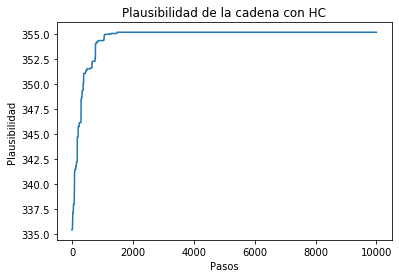

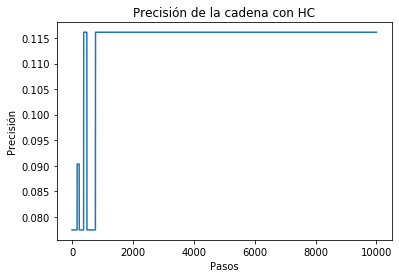

In [44]:
HC_trig, scores_HC_trig, accuracies_HC_trig = HCDecipher(ciphertext, Niter, plaintext, 
                                                           print_period = 1000, plaus_fun = trig_plausibility)
graph_scores(scores_HC_trig, Niter, "Plausibilidad de la cadena con HC")
graph_accuracies(accuracies_HC_trig, Niter, "Precisión de la cadena con HC")
save_chain(HC_trig, scores_HC_trig, accuracies_HC_trig, 'testcorto_trigrama_HC')

### Text Largo

In [46]:
test_text = read_text("bolano_wikipedia.txt")
# Generación de una clave aleatoria
real_key = ''.join(random.sample(alphabet[1:], len(alphabet) - 1)) # El primer caracter es un espacio
print(f"Clave : {real_key}")
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(test_text, keep_punct = True)
print(ciphertext)
print(f"(Tri-)Plausibilidad de la clave real: {trig_plausibility(ciphertext, real_key)}")

Niter = 10000
HC2, scoresHC2, accuraciesHC2 = HCDecipher(ciphertext, Niter, test_text, print_period = 1000, plaus_fun = trig_plausibility)

Clave : IFGSHLUCQTMOPRDJBVNZAKEYWX
VDFHVZD FDOIRD IKIODN NIRZQIUD SH GCQOH KHQRZQDGCD SH IFVQO SH PQO RDKHGQHRZDN GQRGAHRZI W ZVHN  FIVGHODRI BAQRGH SH TAOQD SH SDN PQO ZVHN LAH AR HNGVQZDV W JDHZI GCQOHRD IAZDV SH PIN SH SDN SHGHRIN SH OQFVDN HRZVH ODN GAIOHN SHNZIGIR NAN RDKHOIN ODN SHZHGZQKHN NIOKITHN UIRISDVI SHO JVHPQD CHVVIOSH HR PQO RDKHGQHRZDN RDKHRZI W DGCD W HO JVHPQD VDPAOD UIOOHUDN HR PQO RDKHGQHRZDN RDKHRZI W RAHKH W OI JDNZAPI SDN PQO NHQNGQHRZDN NHNHRZI W NHQN  SHNJAHN SH NA PAHVZH NH CI GDRKHVZQSD HR ARD SH ODN HNGVQZDVHN PIN QRLOAWHRZHN HR OHRUAI HNJIRDOI GDPD OD SHPAHNZVIR OIN RAPHVDNIN JAFOQGIGQDRHN GDRNIUVISIN I NA DFVI W HO CHGCD SH BAH ZVHN RDKHOIN ISHPIN SH OIN WI GQZISIN ODN SHZHGZQKHN NIOKITHN W SDN PQO NHQNGQHRZDN NHNHRZI W NHQN OI FVHKH HNZVHOOI SQNZIRZH LQUAVHR HR ODN BAQRGH JVQPHVDN OAUIVHN SH OI OQNZI GDRLHGGQDRISI HR SDN PQO NQHZH JDV DGCHRZI W AR HNGVQZDVHN W GVQZQGDN OIZQRDIPHVQGIRDN W HNJIRDOHN GDR ODN PHTDVHN GQHR OQFVDN HR OHRUAI GINZHOOIRI SH ODN AO

NameError: name 'scores2' is not defined

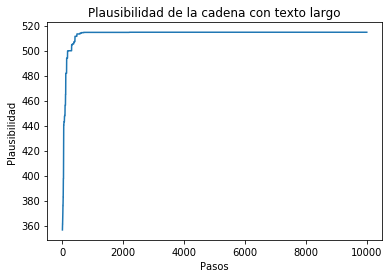

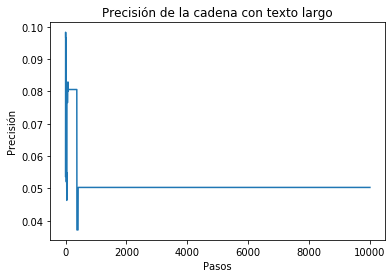

In [48]:
graph_scores(scoresHC2, Niter, "Plausibilidad de la cadena con texto largo")
graph_accuracies(accuraciesHC2, Niter, "Precisión de la cadena con texto largo")
save_chain(HC2, scoresHC2, accuraciesHC2, 'testlargo_trigrama_HC')

## Stochastic Hill Climbing Backtracking

In [106]:
# HC Backtracking
def HCDecipherBack(ciphertext: str, Niter: int, K: int, plaintext,
               initial_key = random.sample(alphabet[1:], len(alphabet) - 1),
               print_solution = False, plaus_fun = plausibility):
    '''
    Función que implementa Hill Climbing Backtracking 
    para el problema de descifrado
    
    Argumentos:
        ciphertext: Código a descifrar
        K: Limite de key repetidas backtracking
        Niter: Número de pasos a realizar
        initial_key (str): una clave inicial para el algoritmo
        print_period: Representa el periodo de actualización. 
            Si no es None, se imprime el estado de la cadena
            y la plausibilidad cada print_period pasos
    
    Retorna:
        key: Estado de la cadena luego de Niter pasos
    '''
    
    U = np.random.uniform(0, 1, size = Niter)
    key = initial_key
    incumbent_plaus = plaus_fun(ciphertext, key)
    incumbent_accuracy = accuracy(plaintext, ciphertext, key)
    keys = [[] for i in range(Niter+1)]
    scores = np.zeros(Niter+1)
    accuracies = np.zeros(Niter+1)
    solutions = [[] for i in range(int(Niter/100))]
    t=0
    j=1
    for i in range(Niter):
        keys[i] = key
        scores[i] = incumbent_plaus
        accuracies[i] = incumbent_accuracy
        new_key = neighbor(key)
        new_plaus = plaus_fun(ciphertext, new_key)
        if new_plaus > incumbent_plaus:
            key = new_key
            incumbent_plaus = new_plaus
            incumbent_accuracy = accuracy(plaintext, ciphertext, key)
            t=0
        if incumbent_plaus>=new_plaus:
            t=t+1
        if t==K:
            solutions[j]=key
            j+=1
            cipher = SimpleSubstitution(key)
            if print_solution==True:
                print(f"Paso {i}")
                print(f"Frase actual: {cipher.decipher(ciphertext, keep_punct = True)}")
                print(f"Plausibilidad: {incumbent_plaus}")
            key = random.sample(alphabet[1:], len(alphabet) - 1)
            incumbent_plaus = plaus_fun(ciphertext, key)
            incumbent_accuracy = accuracy(plaintext, ciphertext, key)
            new_key = neighbor(key)
            new_plaus = plaus_fun(ciphertext, new_key)
    
    #Solucion final backtracking        
    solution = initial_key
    incumbent_plaus = plaus_fun(ciphertext, solution)
    incumbent_accuracy = accuracy(plaintext, ciphertext, solution)            
    for key in solutions:
        if key!=[]:
            plaus_new=plaus_fun(ciphertext,key)
            if plaus_new>incumbent_plaus:
                solution=key
                incumbent_plaus = plaus_new
                incumbent_accuracy = accuracy(plaintext, ciphertext, solution)
    keys[-1]=solution
    scores[-1]=incumbent_plaus
    accuracies[-1]=incumbent_accuracy
    cipher = SimpleSubstitution(solution)
    print(f"Paso final backtrack")
    print(f"Frase actual: {cipher.decipher(ciphertext, keep_punct = True)}")
    print(f"Plausibilidad: {incumbent_plaus}")
    return keys, scores, accuracies

### Text Corto HC Backtracking

Texto cifrado: OHPLYE ATYE CZEUHZE WGZTNZ AK UZKYNYT CZ WHEFKAOFZTNY ZK PYGYTZK AHGZKFATY JHZTCFA GZPYGCY AQHZKKA NAGCZ GZOYNA ZT QHZ EH UACGZ KY KKZXY A PYTYPZG ZK LFZKY
Plausibilidad: 360.2604717419199
Paso 752
Frase actual: NVDPEO YREO KIOBVIO ZFIRSI YA BIAESER KI ZVOCAYNCIRSE IA DEFERIA YVFIACYRE UVIRKCY FIDEFKE YXVIAAY SYFKI FINESY IR XVI OV BYKFI AE AAIME Y DEREDIF IA PCIAE
Plausibilidad: 351.11197693305667
Paso 2003
Frase actual: MIVJEL YREL ZALCIAL KNARBA YS CASEBER ZA KILUSYMUARBE AS VENERAS YINASUYRE FIARZUY NAVENZE YDIASSY BYNZA NAMEBY AR DIA LI CYZNA SE SSATE Y VEREVAN AS JUASE
Plausibilidad: 354.0208394725044
Paso 3171
Frase actual: HANGOY TSOY DRYPARY KIRSMR TE PREOMOS DR KAYFETHFRSMO RE NOIOSRE TAIREFTSO LARSDFT IRNOIDO TZAREET MTIDR IRHOMT RS ZAR YA PTDIR EO EERBO T NOSONRI RE GFREO
Plausibilidad: 351.92613866644444
Paso 4093
Frase actual: WNVUEI AREI LOIZNOI MYORHO AS ZOSEHER LO MNITSAWTORHE OS VEYEROS ANYOSTARE GNORLTA YOVEYLE ADNOSSA HAYLO YOWEHA OR DNO IN ZALYO SE S

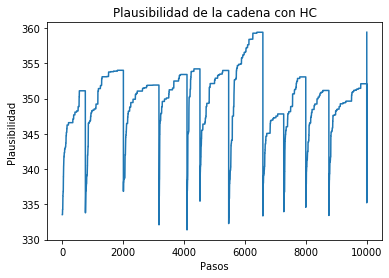

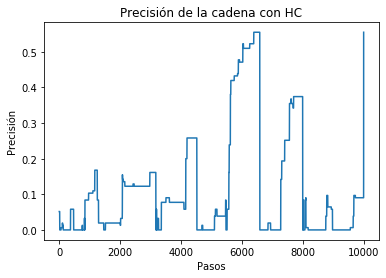

In [84]:
plaintext = "MUCHOS ANOS DESPUES FRENTE AL PELOTON DE FUSILAMIENTO " + \
            "EL CORONEL AURELIANO BUENDIA RECORDO AQUELLA TARDE REMOTA " + \
            "EN QUE SU PADRE LO LLEVO A CONOCER EL HIELO"
real_key = "AJPCZWRLFBDKOTYUQGENHXMIVS"
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(plaintext, keep_punct = True)
print(f"Texto cifrado: {ciphertext}")
print(f"Plausibilidad: {trig_plausibility(ciphertext, real_key)}")
HC_trig, scores_HC_trig, accuracies_HC_trig = HCDecipherBack(ciphertext, Niter, K=100, plaintext, 
                                                           print_solution = True, plaus_fun = trig_plausibility)
graph_scores(scores_HC_trig, Niter+1, "Plausibilidad de la cadena con HC")
graph_accuracies(accuracies_HC_trig, Niter+1, "Precisión de la cadena con HC")

In [85]:
save_chain(HC_trig, scores_HC_trig, accuracies_HC_trig, 'testcorto_trigrama_HC_back')

### Text Largo Backtracking

In [86]:
test_text = read_text("bolano_wikipedia.txt", )
# Generación de una clave aleatoria
real_key = ''.join(random.sample(alphabet[1:], len(alphabet) - 1)) # El primer caracter es un espacio
print(f"Clave : {real_key}")
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(test_text, keep_punct = True)
print(ciphertext)
print(f"(Tri-)Plausibilidad de la clave real: {trig_plausibility(ciphertext, real_key)}")

Niter = 10000
HC2, scoresHC2, accuraciesHC2 = HCDecipherBack(ciphertext, Niter,K=300, test_text, print_solution = True, plaus_fun = trig_plausibility)

Clave : NXJHIZGDTLKSAVEYCFMRQUPWBO
FEXIFRE XESNVE NUNSEM MNVRTNGE HI JDTSI UITVRTEJDE HI NXFTS HI ATS VEUIJTIVREM JTVJQIVRN B RFIM  XNFJISEVN CQTVJI HI LQSTE HI HEM ATS RFIM ZQI QV IMJFTREF B YEIRN JDTSIVE NQREF HI ANM HI HEM HIJIVNM HI STXFEM IVRFI SEM JQNSIM HIMRNJNV MQM VEUISNM SEM HIRIJRTUIM MNSUNLIM GNVNHEFN HIS YFIATE DIFFNSHI IV ATS VEUIJTIVREM VEUIVRN B EJDE B IS YFIATE FEAQSE GNSSIGEM IV ATS VEUIJTIVREM VEUIVRN B VQIUI B SN YEMRQAN HEM ATS MITMJTIVREM MIMIVRN B MITM  HIMYQIM HI MQ AQIFRI MI DN JEVUIFRTHE IV QVE HI SEM IMJFTREFIM ANM TVZSQBIVRIM IV SIVGQN IMYNVESN JEAE SE HIAQIMRFNV SNM VQAIFEMNM YQXSTJNJTEVIM JEVMNGFNHNM N MQ EXFN B IS DIJDE HI CQI RFIM VEUISNM NHIANM HI SNM BN JTRNHNM SEM HIRIJRTUIM MNSUNLIM B HEM ATS MITMJTIVREM MIMIVRN B MITM SN XFIUI IMRFISSN HTMRNVRI ZTGQFIV IV SEM CQTVJI YFTAIFEM SQGNFIM HI SN STMRN JEVZIJJTEVNHN IV HEM ATS MTIRI YEF EJDIVRN B QV IMJFTREFIM B JFTRTJEM SNRTVENAIFTJNVEM B IMYNVESIM JEV SEM AILEFIM JTIV STXFEM IV SIVGQN JNMRISSNVN HI SEM QS

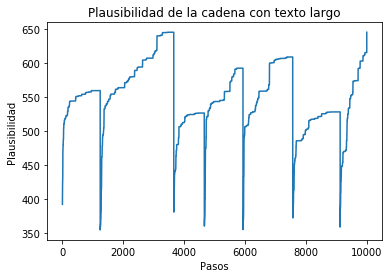

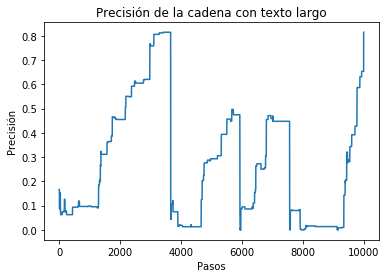

In [87]:
graph_scores(scoresHC2, Niter+1, "Plausibilidad de la cadena con texto largo")
graph_accuracies(accuraciesHC2, Niter+1, "Precisión de la cadena con texto largo")
save_chain(HC2, scoresHC2, accuraciesHC2, 'testlargo_trigrama_HC_back')

### HC Backtracking con distintas Condiciones Iniciales

In [103]:
Niter = 10000
K=400
plaintext = "MUCHOS ANOS DESPUES FRENTE AL PELOTON DE FUSILAMIENTO " + \
            "EL CORONEL AURELIANO BUENDIA RECORDO AQUELLA TARDE REMOTA " + \
            "EN QUE SU PADRE LO LLEVO A CONOCER EL HIELO"
real_key = "AJPCZWRLFBDKOTYUQGENHXMIVS"
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(plaintext, keep_punct = True)

In [104]:
chain, scores, accuracies = HCDecipherBack(ciphertext, Niter, K, plaintext, print_solution = True)

Paso 1792
Frase actual: RIHWAK OSAK UEKMIEK CDESJE ON MENAJAS UE CIKTNORTESJA EN HADASEN OIDENTOSA XIESUTO DEHADUA OVIENNO JODUE DERAJO ES VIE KI MOUDE NA NNEZA O HASAHED EN WTENA
Plausibilidad: 46.68152479819494
Paso 2793
Frase actual: FULHAK ONAK VEKJUEK PDENTE OS JESATAN VE PUKISOFIENTA ES LADANES OUDESIONA GUENVIO DELADVA OQUESSO TODVE DEFATO EN QUE KU JOVDE SA SSEZA O LANALED ES HIESA
Plausibilidad: 48.36279937842444
Paso 3919
Frase actual: CIJPOK ENOK HAKDIAK MZANTA ES DASOTON HA MIKUSECUANTO AS JOZONAS EIZASUENO FIANHUE ZAJOZHO EVIASSE TEZHA ZACOTE AN VIA KI DEHZA SO SSALO E JONOJAZ AS PUASO
Plausibilidad: 47.46716732322048
Paso 5083
Frase actual: WILPAK ENAK JOKDIOK CZONHO ES DOSAHAN JO CIKTSEWTONHA OS LAZANOS EIZOSTENA FIONJTE ZOLAZJA EVIOSSE HEZJO ZOWAHE ON VIO KI DEJZO SA SSORA E LANALOZ OS PTOSA
Plausibilidad: 46.85042298111266
Paso 6059
Frase actual: RJULEY KNEY COYPJOY QZONDO KS POSEDEN CO QJYASKRAONDE OS UEZENOS KJZOSAKNE MJONCAK ZOUEZCE KIJOSSK DKZCO ZOREDK ON IJO YJ PK

In [107]:
## Ataque de bigrama texto corto
incumbent_plaus = 0
incumbent_key = ""
for i in range(20):
    chain, scores, accuracies = HCDecipherBack(ciphertext, Niter, K, plaintext)
    max_index = np.argmax(scores)
    if scores[max_index] > incumbent_plaus:
        incumbent_plaus = scores[max_index]
        incumbent_key = chain[max_index]
    save_chain(chain, scores, accuracies, f'testcortoHC_bigrama_{i+1}')
best_key_bigram_short = incumbent_key

Paso final backtrack
Frase actual: CUJMOK ANOK VEKHUEK PDENTE AS HESOTON VE PUKISACIENTO ES JODONES AUDESIANO GUENVIA DEJODVO AQUESSA TADVE DECOTA EN QUE KU HAVDE SO SSEZO A JONOJED ES MIESO
Plausibilidad: 48.724578269540736
Paso final backtrack
Frase actual: JUHZAY KNAY VEYPUEY CDENTE KS PESATAN VE CUYOSKJOENTA ES HADANES KUDESOKNA GUENVOK DEHADVA KQUESSK TKDVE DEJATK EN QUE YU PKVDE SA SSELA K HANAHED ES ZOESA
Plausibilidad: 47.854130509867446
Paso final backtrack
Frase actual: CUJMOK ANOK VEKHUEK PDENTE AS HESOTON VE PUKISACIENTO ES JODONES AUDESIANO GUENVIA DEJODVO AQUESSA TADVE DECOTA EN QUE KU HAVDE SO SSEZO A JONOJED ES MIESO
Plausibilidad: 48.724578269540736
Paso final backtrack
Frase actual: CIJQOK ANOK TEKVIEK MDENHE AS VESOHON TE MIKUSACUENHO ES JODONES AIDESUANO WIENTUA DEJODTO AFIESSA HADTE DECOHA EN FIE KI VATDE SO SSEZO A JONOJED ES QUESO
Plausibilidad: 47.56223848303838
Paso final backtrack
Frase actual: CUPROK ANOK VEKHUEK LDENTE AS HESOTON VE LUKISACIENTO ES PODONES A

In [108]:
## Ataque de trigrama texto corto
incumbent_plaus = 0
incumbent_key = ""
for i in range(20):
    chain, scores, accuracies = HCDecipherBack(ciphertext, Niter, K, plaintext, 
                                            plaus_fun = trig_plausibility)
    max_index = np.argmax(scores)
    if scores[max_index] > incumbent_plaus:
        incumbent_plaus = scores[max_index]
        incumbent_key = chain[max_index]
    save_chain(chain, scores, accuracies, f'testcortoHC_trigrama_{i+1}')
best_key_trigram_short = incumbent_key

Paso final backtrack
Frase actual: XUPKOS ANOS DESFUES ZRENTE AL FELOTON DE ZUSILAXIENTO EL PORONEL AURELIANO BUENDIA REPORDO AQUELLA TARDE REXOTA EN QUE SU FADRE LO LLEYO A PONOPER EL KIELO
Plausibilidad: 360.54376939911106
Paso final backtrack
Frase actual: BUPKOS AYOS DESVUES ZREYLE AN VENOLOY DE ZUSINABIEYLO EN POROYEN AURENIAYO FUEYDIA REPORDO AQUENNA LARDE REBOLA EY QUE SU VADRE NO NNEJO A POYOPER EN KIENO
Plausibilidad: 360.65775010111815
Paso final backtrack
Frase actual: XLCFOR ASOR VERZLER QUESDE AN ZENODOS VE QLRINAXIESDO EN COUOSEN ALUENIASO BLESVIA UECOUVO ATLENNA DAUVE UEXODA ES TLE RL ZAVUE NO NNEYO A COSOCEU EN FIENO
Plausibilidad: 354.9780827155897
Paso final backtrack
Frase actual: JUPKAS OLAS TESVUES YRELDE ON VENADAL TE YUSINOJIELDA EN PARALEN OURENIOLA BUELTIO REPARTA OQUENNO DORTE REJADO EL QUE SU VOTRE NA NNEZA O PALAPER EN KIENA
Plausibilidad: 358.74558643999774
Paso final backtrack
Frase actual: ZUCMAS OLAS DESPUES BRELYE ON PENAYAL DE BUSTNOZTELYA EN CARALEN O

In [109]:
# Test largo
plaintext = read_text("bolano_wikipedia.txt")
# Generación de una clave aleatoria
real_key = ''.join(random.sample(alphabet[1:], len(alphabet) - 1)) # El primer caracter es un espacio
print(f"Clave : {real_key}")
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(plaintext, keep_punct = True)
print(ciphertext)
print(f"(Tri-)Plausibilidad de la clave real: {trig_plausibility(ciphertext, real_key)}")

Clave : GEIHAOPQRTZNYSBUXKCJLDWFMV
KBEAKJB EBNGSB GDGNBC CGSJRGPB HA IQRNA DARSJRBIQB HA GEKRN HA YRN SBDAIRASJBC IRSILASJG M JKAC  EGKIANBSG XLRSIA HA TLNRB HA HBC YRN JKAC OLA LS ACIKRJBK M UBAJG IQRNASB GLJBK HA YGC HA HBC HAIASGC HA NREKBC ASJKA NBC ILGNAC HACJGIGS CLC SBDANGC NBC HAJAIJRDAC CGNDGTAC PGSGHBKG HAN UKAYRB QAKKGNHA AS YRN SBDAIRASJBC SBDASJG M BIQB M AN UKAYRB KBYLNB PGNNAPBC AS YRN SBDAIRASJBC SBDASJG M SLADA M NG UBCJLYG HBC YRN CARCIRASJBC CACASJG M CARC  HACULAC HA CL YLAKJA CA QG IBSDAKJRHB AS LSB HA NBC ACIKRJBKAC YGC RSONLMASJAC AS NASPLG ACUGSBNG IBYB NB HAYLACJKGS NGC SLYAKBCGC ULENRIGIRBSAC IBSCGPKGHGC G CL BEKG M AN QAIQB HA XLA JKAC SBDANGC GHAYGC HA NGC MG IRJGHGC NBC HAJAIJRDAC CGNDGTAC M HBC YRN CARCIRASJBC CACASJG M CARC NG EKADA ACJKANNG HRCJGSJA ORPLKAS AS NBC XLRSIA UKRYAKBC NLPGKAC HA NG NRCJG IBSOAIIRBSGHG AS HBC YRN CRAJA UBK BIQASJG M LS ACIKRJBKAC M IKRJRIBC NGJRSBGYAKRIGSBC M ACUGSBNAC IBS NBC YATBKAC IRAS NREKBC AS NASPLG IGCJANNGSG HA NBC LN

In [110]:
## Ataque de bigrama texto largo
incumbent_plaus = 0
incumbent_key = ""
for i in range(10):
    chain, scores, accuracies = HCDecipherBack(ciphertext, Niter, K, plaintext)
    max_index = np.argmax(scores)
    if scores[max_index] > incumbent_plaus:
        incumbent_plaus = scores[max_index]
        incumbent_key = chain[max_index]
    save_chain(chain, scores, accuracies, f'testlargoHC_bigrama_{i+1}')
best_key_bigram_long = incumbent_key

Paso final backtrack
Frase actual: ROBERTO BOLANO AVALOK KANTIAPO DE CFILE VEINTIOCFO DE ABRIL DE MIL NOVECIENTOK CINCUENTA Y TREK  BARCELONA QUINCE DE JULIO DE DOK MIL TREK GUE UN EKCRITOR Y HOETA CFILENO AUTOR DE MAK DE DOK DECENAK DE LIBROK ENTRE LOK CUALEK DEKTACAN KUK NOVELAK LOK DETECTIVEK KALVAJEK PANADORA DEL HREMIO FERRALDE EN MIL NOVECIENTOK NOVENTA Y OCFO Y EL HREMIO ROMULO PALLEPOK EN MIL NOVECIENTOK NOVENTA Y NUEVE Y LA HOKTUMA DOK MIL KEIKCIENTOK KEKENTA Y KEIK  DEKHUEK DE KU MUERTE KE FA CONVERTIDO EN UNO DE LOK EKCRITOREK MAK INGLUYENTEK EN LENPUA EKHANOLA COMO LO DEMUEKTRAN LAK NUMEROKAK HUBLICACIONEK CONKAPRADAK A KU OBRA Y EL FECFO DE QUE TREK NOVELAK ADEMAK DE LAK YA CITADAK LOK DETECTIVEK KALVAJEK Y DOK MIL KEIKCIENTOK KEKENTA Y KEIK LA BREVE EKTRELLA DIKTANTE GIPUREN EN LOK QUINCE HRIMEROK LUPAREK DE LA LIKTA CONGECCIONADA EN DOK MIL KIETE HOR OCFENTA Y UN EKCRITOREK Y CRITICOK LATINOAMERICANOK Y EKHANOLEK CON LOK MEJOREK CIEN LIBROK EN LENPUA CAKTELLANA DE LOK UL

In [112]:
## Ataque de trigrama texto largo
incumbent_plaus = 0
incumbent_key = ""
for i in range(10):
    chain, scores, accuracies = HCDecipherBack(ciphertext, Niter, K, plaintext, 
                                            plaus_fun = trig_plausibility)
    max_index = np.argmax(scores)
    if scores[max_index] > incumbent_plaus:
        incumbent_plaus = scores[max_index]
        incumbent_key = chain[max_index]
    save_chain(chain, scores, accuracies, f'testlargoHC_trigrama_{i+1}')
best_key_trigram_long = incumbent_key

Paso final backtrack
Frase actual: ROBARTO BODENO EZEDOS SENTIEVO LA CHIDA ZAINTIOCHO LA EBRID LA JID NOZACIANTOS CINCUANTE Y TRAS  BERCADONE QUINCA LA FUDIO LA LOS JID TRAS GUA UN ASCRITOR Y POATE CHIDANO EUTOR LA JES LA LOS LACANES LA DIBROS ANTRA DOS CUEDAS LASTECEN SUS NOZADES DOS LATACTIZAS SEDZEFAS VENELORE LAD PRAJIO HARREDLA AN JID NOZACIANTOS NOZANTE Y OCHO Y AD PRAJIO ROJUDO VEDDAVOS AN JID NOZACIANTOS NOZANTE Y NUAZA Y DE POSTUJE LOS JID SAISCIANTOS SASANTE Y SAIS  LASPUAS LA SU JUARTA SA HE CONZARTILO AN UNO LA DOS ASCRITORAS JES INGDUYANTAS AN DANVUE ASPENODE COJO DO LAJUASTREN DES NUJAROSES PUBDICECIONAS CONSEVRELES E SU OBRE Y AD HACHO LA QUA TRAS NOZADES ELAJES LA DES YE CITELES DOS LATACTIZAS SEDZEFAS Y LOS JID SAISCIANTOS SASANTE Y SAIS DE BRAZA ASTRADDE LISTENTA GIVURAN AN DOS QUINCA PRIJAROS DUVERAS LA DE DISTE CONGACCIONELE AN LOS JID SIATA POR OCHANTE Y UN ASCRITORAS Y CRITICOS DETINOEJARICENOS Y ASPENODAS CON DOS JAFORAS CIAN DIBROS AN DANVUE CESTADDENE LA DOS UD

In [139]:
print("Plausibidad maxima de HC Backtracking")
incumbent_plaus

Plausibidad maxima de HC Backtracking


649.3253179373315

In [143]:
chain[max_index]

'GEIHAOVQRTZNYSBUXKCJLDWFMP'

In [140]:
print("Precision maxima de HC Backtracking")
accuracies[max_index]

Precision maxima de HC Backtracking


0.8234285714285714

In [ ]:
print("Plausibidad maxima de Simulated Annealing")
incumbent_plaus

## Comparacion de la mejor clave HC

In [121]:
with open('testlargoHC.key', 'w') as f:
    json.dump(real_key, f)

In [125]:
## Test con texto largo

plaintext = read_text("bolano_wikipedia.txt")
# Lectura de la clave
with open("testlargoHC.key", "r") as f:
    real_key = json.load(f)
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(plaintext, keep_punct = True)
    
methods = ['bigrama', 'trigrama']
metrics = ['plausibility', 'accuracy']
longtest_performance = pd.DataFrame(index = methods, columns = metrics)
longtest_performance['plausibility'] = [plausibility(ciphertext, best_key_bigram_long),
                                   trig_plausibility(ciphertext, best_key_trigram_long)]
longtest_performance['accuracy'] = [accuracy(plaintext, ciphertext, best_key_bigram_long),
                                   accuracy(plaintext, ciphertext, best_key_trigram_long)]
longtest_performance

,plausibility,accuracy
bigrama,80.790537,0.015429
trigrama,367.370475,0.015429


In [135]:
real_key

'IMQZKOJXCNHSGEVUWAFBDLRYTP'

In [128]:
best_key_bigram_cipher = SimpleSubstitution(best_key_bigram_long)
print("Texto obtenido por el ataque de bigrama")
best_key_bigram_cipher.decipher(ciphertext, keep_punct=True)

Texto obtenido por el ataque de bigrama


AttributeError: 'SimpleSubstitution' object has no attribute 'cipher'

In [127]:
best_key_trigram_cipher = SimpleSubstitution(best_key_trigram_short)
print("Texto obtenido por el ataque de trigrama")
best_key_trigram_cipher.decipher(ciphertext, keep_punct=True)

Texto obtenido por el ataque de trigrama


'AXWNATX WXGMSX MKMGXI IMSTDMFX EN QYDGN KNDSTDXQYX EN MWADG EN RDG SXKNQDNSTXI QDSQHNSTM Z TANI  WMAQNGXSM BHDSQN EN LHGDX EN EXI RDG TANI CHN HS NIQADTXA Z VXNTM QYDGNSX MHTXA EN RMI EN EXI ENQNSMI EN GDWAXI NSTAN GXI QHMGNI ENITMQMS IHI SXKNGMI GXI ENTNQTDKNI IMGKMLNI FMSMEXAM ENG VANRDX YNAAMGEN NS RDG SXKNQDNSTXI SXKNSTM Z XQYX Z NG VANRDX AXRHGX FMGGNFXI NS RDG SXKNQDNSTXI SXKNSTM Z SHNKN Z GM VXITHRM EXI RDG INDIQDNSTXI ININSTM Z INDI  ENIVHNI EN IH RHNATN IN YM QXSKNATDEX NS HSX EN GXI NIQADTXANI RMI DSCGHZNSTNI NS GNSFHM NIVMSXGM QXRX GX ENRHNITAMS GMI SHRNAXIMI VHWGDQMQDXSNI QXSIMFAMEMI M IH XWAM Z NG YNQYX EN BHN TANI SXKNGMI MENRMI EN GMI ZM QDTMEMI GXI ENTNQTDKNI IMGKMLNI Z EXI RDG INDIQDNSTXI ININSTM Z INDI GM WANKN NITANGGM EDITMSTN CDFHANS NS GXI BHDSQN VADRNAXI GHFMANI EN GM GDITM QXSCNQQDXSMEM NS EXI RDG IDNTN VXA XQYNSTM Z HS NIQADTXANI Z QADTDQXI GMTDSXMRNADQMSXI Z NIVMSXGNI QXS GXI RNLXANI QDNS GDWAXI NS GNSFHM QMITNGGMSM EN GXI HGTDRXI KNDSTDQDSQX MSXI  IH XWAM YM